In [ ]:
#| default_exp bayesianNetworks

In [ ]:
#| export
import numpy as np
import projective_simulation.methods.transforms as transforms

In [ ]:
#| export
class Bayesian_Network:
    def __init__(self, num_sensory_elements, num_m_nodes, W_matrix, C_matrix, m_expectation = None):
        self.num_sensory_elements = num_sensory_elements
        self.num_m_nodes = num_m_nodes
        self.W_matrix = W_matrix  # Shape: (num_sensory_elements, num_m_nodes)
        self.C_matrix = C_matrix  # Shape: (num_m_nodes, num_m_nodes)
        
        # Initialize sensory and m-level variables as empty numpy arrays
        self.sensory_excitation = np.empty(np.shape(W_matrix)[0])
        self.m_excitation = np.empty(num_m_nodes)
        self.m_expectation = np.full(num_m_nodes, fill_value = 1/num_m_nodes) if m_expectation is None else m_expectation
        self.sensory_expectation = np.dot(self.m_expectation, self.W_matrix.T)
        self.m_activation = np.zeros(num_m_nodes)
    
    def excite_network(self, percept):
        """Set the sensory excitation and compute m_excitation."""
        if percept.shape[0] != self.num_sensory_elements:
            raise ValueError("Percept vector size does not match the number of sensory elements.")
        
        self.sensory_excitation = percept  # Set sensory excitation
        
        # Compute m_excitation using equation 1
        self.m_excitation = np.prod(
            np.power(self.W_matrix, self.sensory_excitation[:, np.newaxis]) * 
            np.power(1 - self.W_matrix, (1 - self.sensory_excitation)[:, np.newaxis]),
            axis=0
        )
    
    def activate(self):
        """Compute m_activation based on m_excitation and m_expectation."""
        numerator = self.m_excitation * self.m_expectation
        denominator = np.sum(numerator)
        
        if denominator == 0:
            self.m_activation = np.zeros(self.num_m_nodes)  # Avoid division by zero (network properties are such that this should never happen)
        else:
            self.m_activation = numerator / denominator
    
    def set_expectations(self):
        """Set m_expectation and sensory_expectation based on activation and weight matrices."""
        
        # Normalize C_matrix rows to ensure proper probability distributions
        row_sums = self.C_matrix.sum(axis=1, keepdims=True)
        normalized_C_matrix = np.divide(self.C_matrix, row_sums, where=row_sums!=0)
        
        # Compute m_expectation using the normalized C_matrix
        self.m_expectation = np.dot(self.m_activation, normalized_C_matrix)
        
        # Compute sensory_expectation using W_matrix
        self.sensory_expectation = transforms._shifted_exp(x = np.dot(self.m_expectation, self.W_matrix.T), k = 0)

    def get_surprise(self):
        """Compute the total surprise of the network."""
        
        # Compute individual sensory surprise values
        surprise_values = np.where(
            self.sensory_excitation == 1,
            -np.log2(self.sensory_expectation),
            -np.log2(1 - self.sensory_expectation)
        )
        
        # Sum all sensory surprises to get total surprise
        total_surprise = np.sum(surprise_values)
        
        return total_surprise

In [ ]:
#| export
class Bayesian_Memory(Bayesian_Network):
    def __init__(self, num_sensory_elements, num_m_nodes, W_matrix=None, C_matrix=None, timer=0, sensory_evidence_prior = 1, continuity_prior = 0.95):
        """
        Initialize the Bayesian Memory network.
        :param num_sensory_elements: Number of sensory elements.
        :param num_m_nodes: Number of memory nodes.
        :param W_matrix: Sensory to memory weight matrix, defaults to 0.5 for all weights if None.
        :param C_matrix: Memory transition matrix, defaults to zeros if None.
        :param timer: Integer tracking memory time index, defaults to 0.
        """
        if W_matrix is None:
            W_matrix = np.full((num_sensory_elements, num_m_nodes), fill_value = 0.5)
        if C_matrix is None:
            C_matrix = np.zeros((num_m_nodes, num_m_nodes))
        
        super().__init__(num_sensory_elements, num_m_nodes, W_matrix, C_matrix)
        self.timer = timer
        self.sensory_evidence_prior = sensory_evidence_prior
        self.continuity_prior = continuity_prior
    
    def encode_memory(self):
        """Modify W_matrix and C_matrix to encode sensory input into memory."""
        
        # Update W_matrix based on sensory excitation
        self.W_matrix[:, self.timer] = self.sensory_excitation 
        
        # Update C_matrix based on memory trace
        trace = self.timer
        self.C_matrix[:, trace] = (1 - self.continuity_prior) / (self.num_m_nodes - 1) #keeps wieghts normalized by default
        self.C_matrix[trace - 1, trace] = self.continuity_prior

        #remove excitation from encoded trace
        self.m_excitation[trace] = 0

        self.timer = (self.timer + 1) % self.num_m_nodes

    def excite_network(self, percept):
        """Set the sensory excitation and compute m_excitation."""
        if percept.shape[0] != np.shape(self.W_matrix)[0]:
            raise ValueError("Percept vector size does not match the number of sensory elements.")
        
        self.sensory_excitation = percept  # Set sensory excitation

        weighted_evidence = transforms._logistic(self.W_matrix, x_shift = 0.5, k = self.sensory_evidence_prior)
        # Compute m_excitation using equation 1
        self.m_excitation = np.prod(
            np.power(weighted_evidence, self.sensory_excitation[:, np.newaxis]) *  #changed from the Bayesian Network to apply logistic function
            np.power(1 - weighted_evidence, (1 - self.sensory_excitation)[:, np.newaxis]),
            axis=0
        )

In [ ]:
#| export

class Active_Inference_Memory(Bayesian_Memory):
    def __init__(self, 
                 num_sensory_elements,
                 num_action_elements, 
                 num_m_nodes,
                 intrinsic_expectations = None,
                 W_matrix=None, 
                 C_matrix=None,
                 epsilon = 0.0001,
                 timer=0, 
                 sensory_evidence_prior = 1, 
                 continuity_prior = 0.95):
        """
        Initialize the Bayesian Memory network.
        :param num_sensory_elements: Number of sensory elements.
        :param num_m_nodes: Number of memory nodes.
        :param num_action_elements: number of action elements
        :param W_matrix: Sensory to memory weight matrix, defaults to 0.5 for all weights if None.
        :param C_matrix: Memory transition matrix, defaults to zeros if None.
        :param timer: Integer tracking memory time index, defaults to 0.
        """
        if intrinsic_expectations is None:
            self.intrinsic_expectations = np.zeros(num_sensory_elements)
        else:
            if not len(intrinsic_expectations) == num_sensory_elements:
                raise ValueError("Intrinsic Expectations must be a 1D vector with length equal to the number of sensory elements")
            self.intrinsic_expectations = intrinsic_expectations
        #create W Matrix with rows for both plain sensory elements and active sensory elements
        #because other sensory variables are intialized from this matrix, this is all that is needed
        if W_matrix is None:
            W_matrix = np.full((num_sensory_elements + num_action_elements, num_m_nodes), fill_value = 0.5)
            
        super().__init__(num_sensory_elements, num_m_nodes, W_matrix, C_matrix, timer, sensory_evidence_prior, continuity_prior)
        
        #add action elements to sensory variables
        self.num_action_elements = num_action_elements
        self.action_encoder = np.append(np.zeros(num_sensory_elements), np.ones(num_action_elements)).astype('int') #tracks which sensory elements are actions

        #create a vector for memory valences, to which system surprise is encoded
        self.memory_valences = np.full(num_m_nodes, fill_value = np.nan)

        self.epsilon = epsilon

    def encode_memory(self):
        """Modify W_matrix, C_matrix, and memory valences to encode sensory input into memory."""
        self.memory_valences[self.timer-1] = self.get_surprise()
        super().encode_memory()

    def set_expectations(self):
        """Set m_expectation and sensory_expectation based on activation, valence, and weight matrices."""
        
        # Normalize C_matrix rows to ensure proper probability distributions
        row_sums = self.C_matrix.sum(axis=1, keepdims=True)
        normalized_C_matrix = np.divide(self.C_matrix, row_sums, where=row_sums!=0)
        
        # Compute m_expectation using the normalized C_matrix
        self.m_expectation = np.dot(self.m_activation, normalized_C_matrix)
        
        # Compute weight adjustments based on suprise advantage and action encoder
        priming = np.log(np.nanmean(self.memory_valences)/self.memory_valences)  #used to scale priming of active sensory elements as a function of trace valence
        priming[np.isnan(priming)] = 0 #traces without valence do not prime (including current trace)
        adjusted_weights = np.power(priming[:,np.newaxis], self.action_encoder) * self.W_matrix.T #multiplies weights to active sensory elements by memory trace suprise advantage (and weight to regular sensory elements by 1)
        self.sensory_expectation = np.dot(self.m_expectation, adjusted_weights)
        #adjust expectation based on intrinsic expectations
        #note that this code depends on all plain sensory elements preceding all action representations in the action encoder 
        self.sensory_expectation = np.array([self.sensory_expectation[i] if self.action_encoder[i] == 1 else transforms._shifted_exp(self.sensory_expectation[i], k = self.intrinsic_expectations[i], epsilon = self.epsilon) for i in range(len(self.sensory_expectation))])

    def get_surprise(self):
        """Compute the total surprise of the network."""
        notaction_encoder = [not action for action in self.action_encoder.astype('bool')]
        plain_sensory_excitation = self.sensory_excitation[notaction_encoder]
        # Compute individual sensory surprise values
        surprise_values = np.where(
            plain_sensory_excitation == 1,
            -np.log2(self.sensory_expectation[notaction_encoder]),
            -np.log2(1 - self.sensory_expectation[notaction_encoder])
        )
        
        # Sum all sensory surprises to get total surprise
        total_surprise = np.sum(surprise_values)
        
        return total_surprise

In [ ]:
#| export
class SiPS_ECM(Active_Inference_Memory):
    def __init__(self, 
                 num_sensory_elements,
                 num_action_elements, 
                 num_m_nodes,
                 intrinsic_expectations = None,
                 W_matrix=None, 
                 C_matrix=None,
                 H_matrix = None,
                 h_damp = 0.01,
                 glow_damp = 1,
                 epsilon = 0.0001,
                 timer=0, 
                 sensory_evidence_prior = 1, 
                 continuity_prior = 0.95,
                 deliberation_length: int = 1,
                 reinforcement_strength = 1,
                 place_strength = 0
                ):
        """
        Initialize the Bayesian Memory network.
        :param num_sensory_elements: Number of sensory elements.
        :param num_m_nodes: Number of memory nodes.
        :param num_action_elements: number of action elements
        :param W_matrix: Sensory to memory weight matrix, defaults to 0.5 for all weights if None.
        :param C_matrix: Memory transition matrix, defaults to zeros if None.
        :param timer: Integer tracking memory time index, defaults to 0.
        """
        super().__init__(num_sensory_elements,
                 num_action_elements, 
                 num_m_nodes,
                 intrinsic_expectations,
                 W_matrix, 
                 C_matrix,
                 epsilon,
                 timer, 
                 sensory_evidence_prior, 
                 continuity_prior)
        if H_matrix is None:
            self.H_matrix = np.zeros((num_m_nodes, num_m_nodes))
            for i in range(num_m_nodes):
                self.H_matrix[i,i] = place_strength
        self.H_glow = np.zeros((num_m_nodes, num_m_nodes))
        self.deliberation_length = deliberation_length
        self.h_damp = h_damp
        self.glow_damp = glow_damp
        self.reinforcement_strength = reinforcement_strength

    def activate(self):
        self.m_activation = [0 for _ in self.m_activation]
        position = self.timer
        for tau in range(self.deliberation_length):
            scaled_H = self.H_matrix[position,:] - np.mean(self.H_matrix[position:]) #scale to avoid large numbers. Use the mean because large positive numbers are more likely than large negative numbers (positive edge weights can get used and reinforced repeatedly) 
            projection_weights = np.exp(self.reinforcement_strength * scaled_H) * self.m_excitation * self.m_expectation
            projection_probs = projection_weights/np.sum(projection_weights)
            new_position = np.random.choice(range(len(projection_probs)), p = projection_probs)
            self.H_glow[position,new_position] += 1/self.deliberation_length #add glow at each interval of tau
            self.H_glow = self.H_glow - self.glow_damp/self.deliberation_length * self.H_glow #distribute glow damping over tau (later steps will be more strongly reinforced)
            position = new_position
            self.m_activation[position] += 1
        self.m_activation = self.m_activation/np.sum(self.m_activation)

    def deliberate(self,percept):
        self.excite_network(percept)
        self.encode_memory()
        self.update()
        self.activate()
        self.set_expectations()

    def update(self):
        self.H_matrix = self.H_matrix - self.h_damp * self.H_matrix #return H_matrix weights toward baselinge (presumed to be zero)
        self.H_matrix = self.H_matrix + self.H_glow * np.log(np.nanmean(self.memory_valences)/self.get_surprise()) #reinforce H_matrix weights for edges used to deliberate as a function of surprise advantage
        

In [ ]:
test_SiPS = SiPS_ECM(num_sensory_elements = 2,
                     num_action_elements = 2,
                     num_m_nodes = 50,
                     continuity_prior = 0.5,
                     sensory_evidence_prior = 3,
                     deliberation_length = 5,
                    ) 

print(test_SiPS.m_expectation)
test_SiPS.deliberate(np.array((0,1,0,1)))
print(test_SiPS.m_excitation)

[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
[0.     0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


In [ ]:
print('activation')
print(test_SiPS.m_activation)
print('expectation')
print(test_SiPS.m_expectation)

activation
[0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.
 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.  0.2 0. ]
expectation
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [ ]:
test_SiPS.deliberate(np.array((0,1,0,1)))
print(test_SiPS.m_excitation)

[0.44679602 0.         0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625    ]


In [ ]:
print('activation')
print(test_SiPS.m_activation)
print('expectation')
print(test_SiPS.m_expectation)

activation
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
expectation
[0.02 0.98 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]


In [ ]:
test_SiPS.deliberate(np.array((0,1,0,1)))
print('excitation')
print(test_SiPS.m_excitation)
print('activation')
print(test_SiPS.m_activation)
print('expectation')
print(test_SiPS.m_expectation)

excitation
[0.44679602 0.44679602 0.         0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625    ]
activation
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
expectation
[0.01960784 0.01960784 0.96078431 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

In [ ]:
test_SiPS.H_matrix

array([[3.65842711, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.50761915, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
test_SiPS.deliberate(np.array((0,1,0,1)))
print('excitation')
print(test_SiPS.m_excitation)
print('activation')
print(test_SiPS.m_activation)
print('expectation')
print(test_SiPS.m_expectation)

excitation
[0.44679602 0.44679602 0.44679602 0.         0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625    ]
activation
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
expectation
[0.01923077 0.01923077 0.01923077 0.94230769 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

In [ ]:
test_SiPS.H_matrix

array([[4.77613405, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.52261722, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66270478, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
test_SiPS.deliberate(np.array((1,0,0,1)))
print('excitation')
print(test_SiPS.m_excitation)
print('activation')
print(test_SiPS.m_activation)
print('expectation')
print(test_SiPS.m_expectation)

excitation
[0.02224466 0.02224466 0.02224466 0.02224466 0.         0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625    ]
activation
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
expectation
[0.01886792 0.01886792 0.01886792 0.01886792 0.9245283  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

In [ ]:
test_SiPS.deliberate(np.array((1,0,0,1)))
print('excitation')
print(test_SiPS.m_excitation)
print('activation')
print(test_SiPS.m_activation)
print('expectation')
print(test_SiPS.m_expectation)

excitation
[0.02224466 0.02224466 0.02224466 0.02224466 0.44679602 0.
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625    ]
activation
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
expectation
[0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.90740741
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        

In [ ]:
test_SiPS.deliberate(np.array((0,1,0,1)))
print('excitation')
print(test_SiPS.m_excitation)
print('activation')
print(test_SiPS.m_activation)
print('expectation')
print(test_SiPS.m_expectation)

excitation
[0.44679602 0.44679602 0.44679602 0.44679602 0.02224466 0.02224466
 0.         0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625    ]
activation
[0.  0.  0.2 0.  0.2 0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
expectation
[0.01818182 0.01818182 0.01818182 0.19272727 0.01818182 0.19272727
 0.54181818 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

In [ ]:
#| export
class Hebbian_Reinforcement_SiPS(SiPS_ECM):

    def update(self):
        self.H_matrix = self.H_matrix - self.h_damp * self.H_matrix #return H_matrix weights toward baseline (presumed to be zero)
        self.H_glow = self.H_glow - self.glow_damp * self.H_glow #returns glow toward baseline (presumed to be 0)
        hebbian_connections = np.outer(self.m_activation, self.m_activation) #establish connections between traces activated by deliberation
        hebbian_connections[self.timer,:] = self.m_activation #establish connections between current trace and traces activated by deliberation
        self.H_glow = self.H_glow + hebbian_connections
        self.H_matrix = self.H_matrix + self.H_glow * np.log(np.nanmean(self.memory_valences)/self.get_surprise()) #reinforce H_matrix weights connecting activated traces
        
    def activate(self):
        self.m_activation = [0 for _ in self.m_activation]
        position = self.timer
        for tau in range(self.deliberation_length):
            scaled_H = self.H_matrix[position,:] - np.mean(self.H_matrix[position:]) #scale to avoid large numbers. Use the mean because large positive numbers are more likely than large negative numbers (positive edge weights can get used and reinforced repeatedly) 
            projection_weights = np.exp(self.reinforcement_strength * scaled_H) * self.m_excitation * self.m_expectation
            projection_probs = projection_weights/np.sum(projection_weights)
            new_position = np.random.choice(range(len(projection_probs)), p = projection_probs)
            position = new_position
            self.m_activation[position] += 1
        self.m_activation = self.m_activation/np.sum(self.m_activation)
   

In [ ]:
test_HR = Hebbian_Reinforcement_SiPS(num_sensory_elements = 2,
                     num_action_elements = 2,
                     num_m_nodes = 50,
                     continuity_prior = 0.7,
                     sensory_evidence_prior = 7,
                     deliberation_length = 20
                    ) 

print(test_HR.m_expectation)
test_HR.deliberate(np.array((0,1,0,1)))
print(test_HR.m_excitation)

[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
[0.     0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


In [ ]:
from projective_simulation.visualization import plot_heatmap

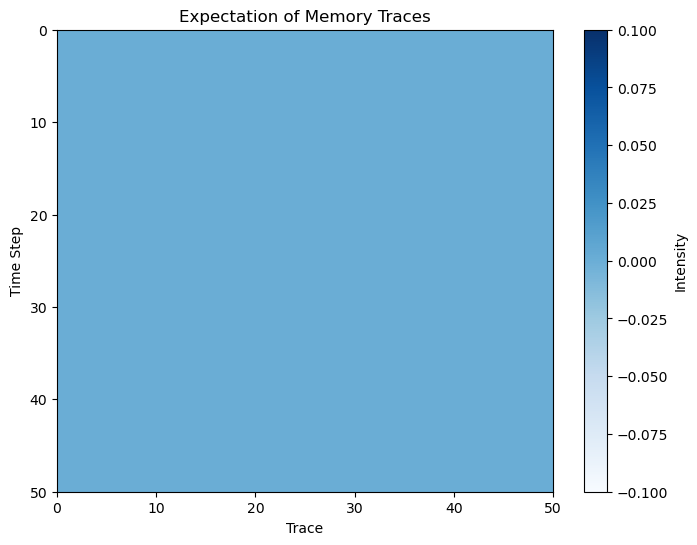

In [ ]:
plot_heatmap(test_HR.H_glow)

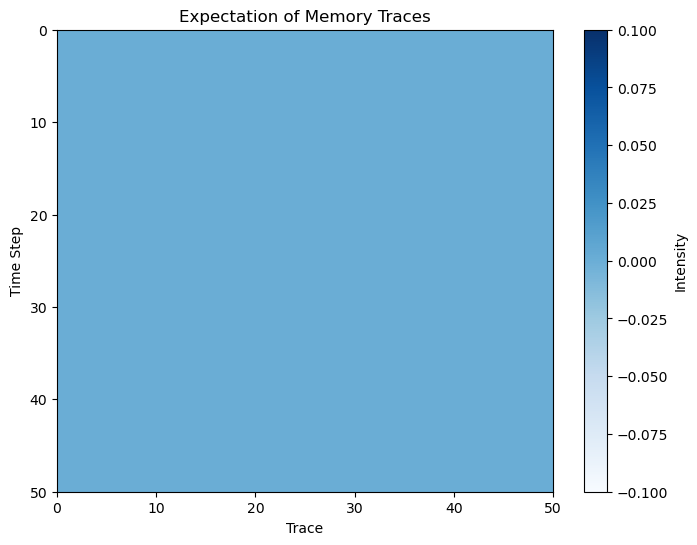

In [ ]:
plot_heatmap(test_HR.H_matrix)

In [ ]:
print(test_HR.m_expectation)
test_HR.deliberate(np.array((1,0,0,1)))
print(test_HR.m_excitation)

[0.00817439 0.00817439 0.05449591 0.00817439 0.00817439 0.00817439
 0.00817439 0.00817439 0.88828338 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[8.09574568e-04 8.09574568e-04 8.09574568e-04 8.09574568e-04
 8.09574568e-04 8.09574568e-04 8.87806315e-01 8.87806315e-01
 8.87806315e-01 0.00000000e+00 6.25000000e-02 6.25000000e-02
 6.25000000e-02 6.25000000e-02 6.25000000e-02 6.25000000e-02
 6.25000000e-02 6.25000000e-02 6.25000000e-02 6.25000000e-02
 6.25000000e-02 6.25000000e-02 6.25000000e-02 6.25000000e-02
 6.25000000e-02 6.25000000e-02 6.25000000e-02 6.25000000e-02
 6.25000000e-02 6.25000000e-02 6.25000000e-02 6.25000000e-02
 6.25000

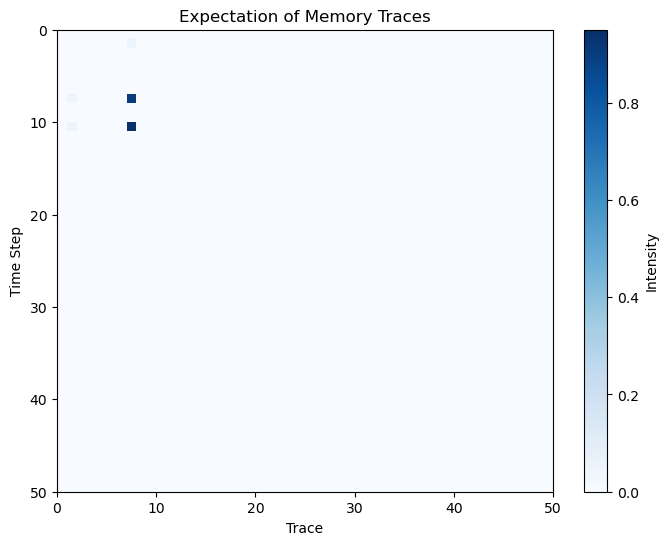

In [ ]:
plot_heatmap(test_HR.H_glow)

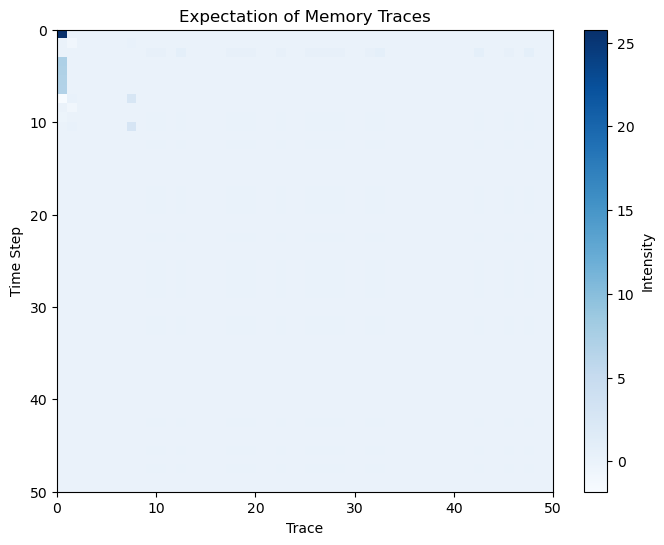

In [ ]:
plot_heatmap(test_HR.H_matrix)

In [ ]:
print(test_HR.m_activation)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


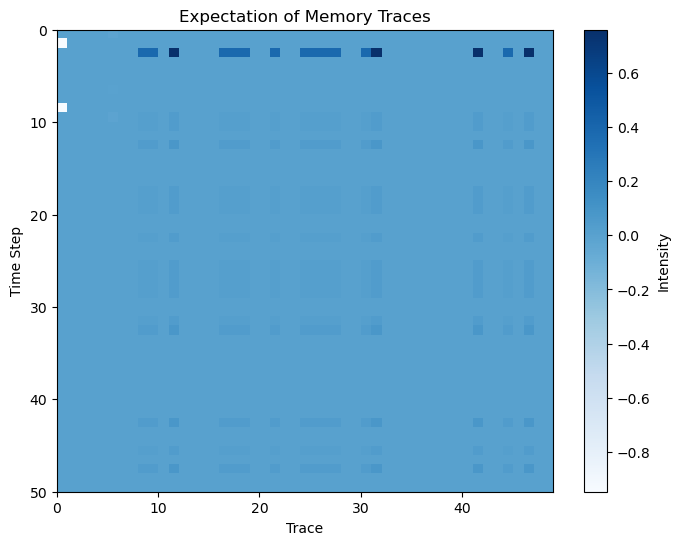

In [ ]:
plot_heatmap(test_HR.H_matrix[:,1:])

In [ ]:
test_HR.timer

9

In [ ]:
#| export
class Basic_Agent():
    def __init__(self,active_inference_memory, action_softmax_temp = 1):
        self.memory_network = active_inference_memory
        self.num_actions = active_inference_memory.num_action_elements
        self.action = None
        self.action_softmax_temp = action_softmax_temp

    def get_action(self):
        '''
        choose an action based on expectations of memory network set in previous step
        '''
        primes = self.memory_network.sensory_expectation[self.memory_network.action_encoder.astype('bool')]
        primes_softmax = transforms._softmax(self.action_softmax_temp,primes) #use softmax to nomormalize over real values and get probabilities
        self.action = np.random.choice(self.num_actions, p = primes_softmax)
        return(self.action)

    def deliberate(self,observation):
        '''
        evaluate current state and make predictions
        '''
        action_representation = np.zeros(self.num_actions)
        action_representation[self.action] = 1
        percept = np.append(observation, action_representation)
        self.memory_network.excite_network(percept)
        self.memory_network.encode_memory()
        self.memory_network.activate()
        self.memory_network.set_expectations()   

In [ ]:
#| export
class Flip_Generator:
    def __init__(self, probabilities, transitions, state):
        """
        Initialize the flip generator.
        :param probabilities: NxD numpy array of probabilities for generating binary vectors. N gives the number of coins/bits and D the number of system states
        :param transitions: DxD numpy array representing state transition probabilities.
        :param state: Integer representing the initial state.
        """
        self.probabilities = probabilities
        self.transitions = transitions
        self.state = state
        self.D, self.N = probabilities.shape  # Number of states (D) and vector length (N)
        
        # Assertions to ensure correct dimensionality
        assert transitions.shape == (self.D, self.D), "Transitions matrix must be DxD."
        assert probabilities.shape[1] == transitions.shape[1], "Probabilities and transitions must have the same number of states (D)."
        assert np.allclose(transitions.sum(axis=1), 1), "Each row of the transition matrix must sum to 1."
    
    def generate(self):
        """
        Generate a binary vector based on the current state and transition probabilities.
        :return: Generated binary array (1D numpy array of length N)
        """
        # Generate a binary vector where each element is 1 with probability P_{i, j}
        binary_array = np.random.rand(self.N) < self.probabilities[:,self.state]
        
        # Sample the next state from the transition probabilities
        self.state = np.random.choice(self.D, p=self.transitions[self.state])
        
        return binary_array

class Controlled_Flip_Generator:
    def __init__(self, probabilities, transitions, state = 0):
        """
        Initialize the flip generator.
        :param probabilities: NxD numpy array of probabilities for generating binary vectors. N gives the number of coins/bits and D the number of system states
        :param transitions: AxDxD numpy array representing state transition probabilities, where A is the size of an agents action space.
        :param state: Integer representing the initial state.
        """
        self.probabilities = probabilities
        self.transitions = transitions
        self.state = state
        self.D, self.N = probabilities.shape  # Number of states (D) and vector length (N)
        
        # Assertions to ensure correct dimensionality
        assert probabilities.shape[1] == transitions.shape[1], "Probabilities and transitions must have the same number of states (D)."
    
    def generate(self, action):
        """
        Generate a binary vector based on the current state and transition probabilities.
        :return: Generated binary array (1D numpy array of length N)
        """
        self.state = np.random.choice(self.D, p=self.transitions[action,self.state,:])
        # Generate a binary vector where each element is 1 with probability P_{i, j}
        binary_array = np.random.rand(self.N) < self.probabilities[:,self.state]
        
        return binary_array